In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import torch.optim as optim
from pytorch_metric_learning import losses, miners
import os
import math

# Parameters

In [68]:
eyeset = 10
crnn = 0
ratio = 0.25
lr = 1e-4
l2 = 1e-4
num_early = 1000
w_metric_loss: float = 1
w_class_loss: float = 1
alpha = 2
beta = 50
depth = 4
focal = 1
batch_size = 128
model_output = 128

# Data

In [69]:
data_info = pd.read_excel('./data/data_with_mmse1.xlsx', sheet_name='60以上-1706人')
# data_info = pd.read_excel('./data/data_encoded_del_0724.xlsx')

In [70]:
data_info = data_info.loc[data_info['del'] != 1]
data_info['name'] = data_info['name'].str.replace('[:,.]', '', regex=True)

In [71]:
print(data_info.columns.tolist())

['编号', 'id', 'name', '性别-更新', '文化程度-更新', '出生年份', '年龄', '婚姻状况', '社康', 'audio_url', 'resources_url', 'conclusion', 'VR注视时长得分（平均分）', '注意力', '抽象力', '计算力-1', '计算力-2', '计算力-3', '执行力', '记忆力-1', '记忆力-2', '记忆力-3', '回忆', 'MMSE得分', 'MMSE_Threshold', 'mmse_diag', '定向力-1', '定向力-2', '定向力-3', '定向力-4', '定向力-5', '定向力-6', '定向力-7', '定向力-8', '定向力-9', '定向力-10', '即时记忆', '注意力和计算力', '延时回忆', '语言能力-1', '语言能力-2', '语言能力-3', '语言能力-4', '语言能力-5', '语言能力-6', '语言能力-7', 'AD8总分', 'TITLE1', 'TITLE0', 'TITLE0.1', 'TITLE4', 'TITLE5', 'TITLE6', 'TITLE7', 'TITLE8', 'Score', 'del']


In [73]:
data_info.shape

(1563, 57)

In [8]:
# True is patient, False is normal
def get_diag(row):
    if row["文化程度-更新"] == "中学及以上":
        return row["MMSE得分"] <= 24
    elif row["文化程度-更新"] == "小学":
        return row["MMSE得分"] <= 20
    else:
        return row["MMSE得分"] <= 17

# data_info["MMSE_diag"] = data_info.apply(get_diag, axis=1)

In [59]:
# nc_info = data_info.loc[data_info['mmse_diag'] == False, ['id', 'name']]
# ci_info = data_info.loc[data_info['mmse_diag'] == True, ['id', 'name']]
nc_info = data_info.loc[data_info['MMSE得分'] >= 27, ['id', 'name']]
ci_info = data_info.loc[data_info['MMSE得分'] < 27, ['id', 'name']]
print(nc_info.shape, ci_info.shape, nc_info.shape[0]/(nc_info.shape[0] + ci_info.shape[0]))

(982, 2) (580, 2) 0.6286811779769527


In [10]:
from sklearn.model_selection import train_test_split

train_nc, test_nc = train_test_split(nc_info, test_size=299)
train_nc, valid_nc = train_test_split(train_nc, test_size=0.2)

In [11]:
new_t = np.linspace(0, 11000, 770).round(0)
# np.interp(new_t, tmp['timestamp'].values, tmp['pos_x'].values)

## Dataset

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

level_list = [i for i in range(2, 12)]

X, y = data_info[['id', 'name']], data_info['mmse_diag']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
print(X_train.shape, X_valid.shape, X_test.shape)

(1000, 2) (250, 2) (313, 2)


### Classified data into 10 parts

In [13]:
class EyeSet10(Dataset):
    def __init__(self, sub_info: pd.DataFrame, sub_labels: pd.DataFrame) -> None:
        super().__init__()
        self.sub_info = sub_info.values
        self.sub_labels = torch.Tensor(sub_labels.values).unsqueeze(-1)
        self.metadata = [
            [
                torch.Tensor(pd.read_csv(f'./data/q_splitted_interpolated/Q{level}/{id}-{name}-{level}-S2.csv', usecols=['x', 'y']).values.T)
                for level in level_list
            ]
            for id, name in self.sub_info
        ]
    
    def __len__(self):
        return self.sub_info.shape[0]
    
    def __getitem__(self, index):
        # id, name = self.sub_info[index]
        return self.metadata[index], self.sub_labels[index]

In [14]:
class EyeSet10Velo(Dataset):
    def __init__(self, sub_info: pd.DataFrame, sub_labels: pd.DataFrame) -> None:
        super().__init__()
        self.sub_info = sub_info.values
        self.sub_labels = torch.Tensor(sub_labels.values).unsqueeze(-1)
        self.metadata = [
            [
                self.transform_data(
                    pd.read_csv(f'./data/q_splitted_interpolated/Q{level}/{id}-{name}-{level}-S2.csv', usecols=['x', 'y']).values
                )
                for level in range(2, 12)
            ]
            for id, name in self.sub_info
        ]
    
    def __len__(self):
        return self.sub_info.shape[0]
    
    def __getitem__(self, index):
        return self.metadata[index], self.sub_labels[index]
    
    def calculate_velocity(self, positions):
        # Calculate velocities by taking the difference between consecutive positions
        velocities_x = np.diff(positions[:, 0])
        velocities_y = np.diff(positions[:, 1])
        return velocities_x, velocities_y

    def transform_data(self, positions):
        velocities_x, velocities_y = self.calculate_velocity(positions)
        
        # Perform z-score normalization
        velocities_mean_x = np.mean(velocities_x, keepdims=True)
        velocities_std_x = np.std(velocities_x, keepdims=True)
        velocities_x = (velocities_x - velocities_mean_x) / velocities_std_x

        velocities_mean_y = np.mean(velocities_y, keepdims=True)
        velocities_std_y = np.std(velocities_y, keepdims=True)
        velocities_y = (velocities_y - velocities_mean_y) / velocities_std_y
        
        # Define constants
        c = 0.03  # Tuned within the range of 0.01 to 0.06
        vmin = 20  # Tuned within the range of 10 to 60

        # Apply the transformations for slow and fast movements
        slow_velocities_x = np.tanh(c * velocities_x)
        slow_velocities_y = np.tanh(c * velocities_y)

        fast_velocities_x = np.where(
            np.sqrt(velocities_x**2 + velocities_y**2) < vmin,
            np.zeros_like(velocities_x),
            velocities_x
        )
        fast_velocities_y = np.where(
            np.sqrt(velocities_x**2 + velocities_y**2) < vmin,
            np.zeros_like(velocities_y),
            velocities_y
        )

        slow_velocities = np.vstack((slow_velocities_x, slow_velocities_y))
        fast_velocities = np.vstack((fast_velocities_x, fast_velocities_y))

        combined_velocities = np.vstack((slow_velocities, fast_velocities))

        # print(torch.Tensor(combined_velocities).shape)
        return torch.Tensor(combined_velocities)



### Classified as 9 parts, exclude question 2

In [15]:
class EyeSet9Velo(Dataset):
    def __init__(self, sub_info: pd.DataFrame, sub_labels: pd.DataFrame) -> None:
        super().__init__()
        self.sub_info = sub_info.values
        self.sub_labels = torch.Tensor(sub_labels.values).unsqueeze(-1)
        self.metadata = [
            [
                self.transform_data(
                    pd.read_csv(f'./data/q_splitted_interpolated/Q{level}/{id}-{name}-{level}-S2.csv', usecols=['x', 'y']).values
                )
                for level in range(3, 12)
            ]
            for id, name in self.sub_info
        ]
    
    def __len__(self):
        return self.sub_info.shape[0]
    
    def __getitem__(self, index):
        return self.metadata[index], self.sub_labels[index]
    
    def calculate_velocity(self, positions):
        # Calculate velocities by taking the difference between consecutive positions
        velocities_x = np.diff(positions[:, 0])
        velocities_y = np.diff(positions[:, 1])
        return velocities_x, velocities_y

    def transform_data(self, positions):
        velocities_x, velocities_y = self.calculate_velocity(positions)
        
        # Perform z-score normalization
        velocities_mean_x = np.mean(velocities_x, keepdims=True)
        velocities_std_x = np.std(velocities_x, keepdims=True)
        velocities_x = (velocities_x - velocities_mean_x) / velocities_std_x

        velocities_mean_y = np.mean(velocities_y, keepdims=True)
        velocities_std_y = np.std(velocities_y, keepdims=True)
        velocities_y = (velocities_y - velocities_mean_y) / velocities_std_y
        
        # Define constants
        c = 0.03  # Tuned within the range of 0.01 to 0.06
        vmin = 20  # Tuned within the range of 10 to 60

        # Apply the transformations for slow and fast movements
        slow_velocities_x = np.tanh(c * velocities_x)
        slow_velocities_y = np.tanh(c * velocities_y)

        fast_velocities_x = np.where(
            np.sqrt(velocities_x**2 + velocities_y**2) < vmin,
            np.zeros_like(velocities_x),
            velocities_x
        )
        fast_velocities_y = np.where(
            np.sqrt(velocities_x**2 + velocities_y**2) < vmin,
            np.zeros_like(velocities_y),
            velocities_y
        )

        slow_velocities = np.vstack((slow_velocities_x, slow_velocities_y))
        fast_velocities = np.vstack((fast_velocities_x, fast_velocities_y))

        combined_velocities = np.vstack((slow_velocities, fast_velocities))

        # print(torch.Tensor(combined_velocities).shape)
        return torch.Tensor(combined_velocities)



### Classified data into 6 parts

In [16]:
class EyeSet6(Dataset):
    def __init__(self, sub_info: pd.DataFrame, sub_labels: pd.DataFrame) -> None:
        super().__init__()
        self.sub_info = sub_info.values
        self.sub_labels = torch.Tensor(sub_labels.values).unsqueeze(-1)
        self.metadata = [
            [
                torch.Tensor(pd.read_csv(f'./data/q_splitted_interpolated/Q{level}/{id}-{name}-{level}-S2.csv', usecols=['x', 'y']).values.T)
                for level in level_list
            ]
            for id, name in self.sub_info
        ]
    
    def __len__(self):
        return self.sub_info.shape[0]
    
    def __getitem__(self, index):
        data = self.metadata[index]
        
        # Combine questions in the specified way
        question_2 = data[0]
        question_3 = data[1]
        questions_4_6 = torch.cat(data[2:5], dim=1)
        question_7 = data[5]
        questions_8_10 = torch.cat(data[6:9], dim=1)
        question_11 = data[9]
        
        combined_data = [question_2, question_3, questions_4_6, question_7, questions_8_10, question_11]
        
        return combined_data, self.sub_labels[index]

### Classified data into 2 parts

In [17]:
class EyeSet2(Dataset):
    def __init__(self, sub_info: pd.DataFrame, sub_labels: pd.DataFrame) -> None:
        super().__init__()
        self.sub_info = sub_info.values
        self.sub_labels = torch.Tensor(sub_labels.values).unsqueeze(-1)
        self.metadata = [
            [
                torch.Tensor(pd.read_csv(f'./data/q_splitted_interpolated/Q{level}/{id}-{name}-{level}-S2.csv', usecols=['x', 'y']).values.T)
                for level in level_list
            ]
            for id, name in self.sub_info
        ]
    
    def __len__(self):
        return self.sub_info.shape[0]
    
    def __getitem__(self, index):
        # id, name = self.sub_info[index]
        # Get the tensor for question 2
        question_2_tensor = self.metadata[index][0]
        
        # Concatenate tensors for questions 3 to 11
        concatenated_tensor = torch.cat(self.metadata[index][1:], dim=1)
        
        return [question_2_tensor, concatenated_tensor], self.sub_labels[index]

### CNN and RNN data generation 

In [18]:
def save_scanpath_image(positions, save_path, fig_size=(8, 6), dpi=100):  # Default figure size
    os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
    plt.figure(figsize=fig_size, dpi=dpi)  # Set the figure size
    plt.plot(positions[:, 0], positions[:, 1], 'o-', markersize=1, linewidth=0.5)  # Draw the scanpath
    plt.axis('off')  # Turn off the axis
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)  # Save the figure without extra space
    plt.close()

def query_data(sub_info: pd.DataFrame, sub_labels: pd.DataFrame, img_size = (64, 64), img_dir: str = './data/scanpath_images') -> None:
    sub_inf = sub_info.values
    for id, name in sub_inf:
        for level in range(2, 12):
            save_scanpath_image(
                pd.read_csv(f'./data/q_splitted_interpolated/Q{level}/{id}-{name}-{level}-S2.csv', usecols=['x', 'y']).values,
                f'{img_dir}/Q{level}/{id}_{name}_Q{level}.png'
            )

In [19]:

from PIL import Image

class EyeSetCRNN(Dataset):
    def __init__(self, sub_info: pd.DataFrame, sub_labels: pd.DataFrame, img_size = (64, 64), img_dir: str = './data/scanpath_images') -> None:
        super().__init__()
        self.sub_info = sub_info.values
        self.sub_labels = torch.Tensor(sub_labels.values).unsqueeze(-1)
        self.img_size = img_size
        self.img_dir = img_dir
        # self.data_paths = [
        #     [
        #         (f'./data/q_splitted_interpolated/Q{level}/{id}-{name}-{level}-S2.csv',
        #          f'{self.img_dir}/Q{level}/{id}_{name}_Q{level}.png')
        #         for level in range(2, 12)
        #     ]
        #     for id, name in self.sub_info
        # ]
        self.metadata = [
            [
                self.transform_data(
                    f'{self.img_dir}/Q{level}/{id}_{name}_Q{level}.png'
                    
                )
                for level in range(2, 12)
            ]
            for id, name in self.sub_info
        ]
    
    def __len__(self):
        return self.sub_info.shape[0]
    
    def __getitem__(self, index):
        # csv_path, img_path = self.data_paths[index][0]
        # positions = pd.read_csv(csv_path, usecols=['x', 'y']).values
        # img = self.transform_data(positions, img_path)
        # return img, self.sub_labels[index]
        return self.metadata[index], self.sub_labels[index]
    
    def transform_data(self, img_path):
        # Load the image
        # save_scanpath_image(positions, img_path, fig_size=(8, 6), dpi=100)
        img = plt.imread(img_path)
        img = torch.Tensor(img).permute(2, 0, 1)  # Convert to (C, H, W) format for PyTorch
        return img

### Load Data

In [20]:
if eyeset == 10 and crnn == 0:
    # To tensor format
    # train_set = EyeSet10(X_train, y_train) # (1000, 2, 770)
    # valid_set = EyeSet10(X_valid, y_valid)
    # test_set = EyeSet10(X_test, y_test)
    train_set = EyeSet10Velo(X_train, y_train) # (1000, 2, 770)
    valid_set = EyeSet10Velo(X_valid, y_valid)
    test_set = EyeSet10Velo(X_test, y_test)
elif eyeset == 9 and crnn == 0:
    train_set = EyeSet9Velo(X_train, y_train) # (1000, 2, 770)
    valid_set = EyeSet9Velo(X_valid, y_valid)
    test_set = EyeSet9Velo(X_test, y_test)
elif eyeset == 6 and crnn == 0:
    # To tensor format
    train_set = EyeSet6(X_train, y_train)
    valid_set = EyeSet6(X_valid, y_valid)
    test_set = EyeSet6(X_test, y_test)
elif eyeset == 2 and crnn == 0:
    # To tensor format
    train_set = EyeSet2(X_train, y_train)
    valid_set = EyeSet2(X_valid, y_valid)
    test_set = EyeSet2(X_test, y_test)
elif crnn == 1:
    train_set = EyeSetCRNN(X_train, y_train)
    valid_set = EyeSetCRNN(X_valid, y_valid)
    test_set = EyeSetCRNN(X_test, y_test)

In [21]:
print(len(train_set))

1000


## DataLoader

In [22]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True, pin_memory_device='cuda')

# Model

In [23]:
import torch
import torch.nn as nn

In [24]:
for i in range(2, 12):
    sample = pd.read_csv('./data/q_splitted_interpolated/Q{}/11639-靳保国-{}-S2.csv'.format(i, i), usecols=['x', 'y']).T.values
    sample = torch.Tensor(sample)
    print(f"Input shape of question {i}: {sample.shape}")
rand_sample = torch.randn(128, 2, 490)

Input shape of question 2: torch.Size([2, 770])
Input shape of question 3: torch.Size([2, 490])
Input shape of question 4: torch.Size([2, 490])
Input shape of question 5: torch.Size([2, 490])
Input shape of question 6: torch.Size([2, 490])
Input shape of question 7: torch.Size([2, 490])
Input shape of question 8: torch.Size([2, 490])
Input shape of question 9: torch.Size([2, 490])
Input shape of question 10: torch.Size([2, 490])
Input shape of question 11: torch.Size([2, 490])


## weight init

In [25]:
def init_weights(model):
    for encoder in model.encoders:
        for m in encoder.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
    
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Linear):
            nn.init.constant_(m.bias, 0.0)

### DenseNet

In [26]:
class ConvBlock(nn.Module):
    """BatchNorm1d + ReLU + Conv1d"""

    def __init__(
        self,
        input_channels: int,
        output_channels: int,
        dilation: int = 1,
        kernel_size: int = 3,
    ):
        super().__init__()
        self.bn = nn.BatchNorm1d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv1d(
            input_channels,
            output_channels,
            kernel_size=kernel_size,
            stride=1,
            padding="same",
            dilation=dilation,
            bias=False,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = x
        if self.bn is not None:
            out = self.bn(out)
        if self.relu is not None:
            out = self.relu(out)
        out = self.conv(out)
        return torch.cat([x, out], dim=1)
    
class DenseBlock(nn.Module):
    """Series of convolution blocks with dense connections."""

    def __init__(
        self,
        n_layers: int,
        input_channels: int,
        growth_rate: int,
        max_dilation: int = 64,
        kernel_size: int = 3,
    ):
        super().__init__()

        dilation_exp_mod = int(np.log2(max_dilation)) + 1

        def dilation_at_i(i: int) -> int:
            return 2 ** (i % dilation_exp_mod)

        layers = [
            ConvBlock(
                input_channels=input_channels + i * growth_rate,
                output_channels=growth_rate,
                dilation=dilation_at_i(i),
                kernel_size=kernel_size,
            )
            for i in range(n_layers)
        ]
        self.block_sequence = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block_sequence(x)
        return x
    
class SimpleDenseNet(nn.Module):
    """
    Network with a single dense block.

    References
    ----------
    https://github.com/andreasveit/densenet-pytorch/blob/master/densenet.py
    """

    def __init__(
        self,
        depth: int,
        output_dim: int,
        growth_rate: int = 32,
        initial_channels: int = 2,
        max_dilation: int = 64,
        kernel_size: int = 3,
    ):
        super().__init__()

        n_fixed_layers = 1  # embedding layer
        n_layers_per_block = depth - n_fixed_layers
        assert n_layers_per_block > 0, "`depth` is too small"

        input_channels = initial_channels

        # Single dense block
        layers = [
            DenseBlock(
                n_layers_per_block,
                input_channels,
                growth_rate,
                max_dilation=max_dilation,
                kernel_size=kernel_size,
            )
        ]
        input_channels += n_layers_per_block * growth_rate
        self.block_sequence = nn.Sequential(*layers)

        # Global average pooling and embedding layer
        self.bn2 = nn.BatchNorm1d(input_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(input_channels, output_dim)

        self.output_dim = output_dim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block_sequence(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

### CNN and RNN

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self, output_dim: int = 50):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64, output_dim)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

    def forward(self, x):
        # (batch_size, 3, 462, 620)
        x = self.conv1(x)
        #(batch_size, 32, 462, 620)
        x = self.relu(x)
        x = self.pool1(x)
        # (batch_size, 32, 231, 310)

        x = self.conv2(x)
        # (batch_size, 64, 231, 310)
        x = self.relu(x)
        x = nn.AdaptiveMaxPool2d((1, 1))(x)
        # (batch_size, 64, 1, 1)

        x = x.view(x.size(0), -1)
        # (batch_size, 64, 1)
        
        x = self.flatten(x)
        x = self.fc1(x)
        # (batch_size, output_dim)
        
        return x

### Classifier

In [28]:
from typing import List

class EyeClassifierLayer(nn.Module):
    def __init__(self, device, initial_channels: int = 2, output_dim: int = 128, eyeset: int = 10, crnn: int = 0) -> None:
        super().__init__()
        # self.encoder_1, self.encoder_2, self.encoder_3, self.encoder_4, self.encoder_5, self.encoder_6, self.encoder_7, self.encoder_8, self.encoder_9, self.encoder_10 = \
        # [PursuitConvEncoder() for i in range(10)]
        # self.encoders = [PursuitConvEncoder(initial_channels, output_dim).to(device) for _ in range(10)]
        self.eyeset = eyeset
        if crnn == 0:
            self.encoders = [SimpleDenseNet(depth=depth, output_dim=output_dim, initial_channels=initial_channels).to(device) for _ in range(self.eyeset)]
        elif crnn == 1:
            self.encoders = [SimpleCNN(output_dim=output_dim).to(device) for _ in range(self.eyeset)]
        
        self.fc_1 = nn.Linear(self.eyeset * output_dim, 256)
        self.fc_2 = nn.Linear(256, 1)
        self.bn1 = nn.BatchNorm1d(self.eyeset * output_dim)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, input: List[torch.Tensor]):
        if self.eyeset == 10 or self.eyeset == 9:
            embeddings = [encoder(x) for encoder, x in zip(self.encoders, input)]
            embedding = torch.cat(embeddings, dim=-1) # (b, self.eyeset * output_dim)
        
        elif self.eyeset == 6:
            question_2_tensor, question_3_tensor, questions_4_6_tensor, question_7_tensor, questions_8_10_tensor, question_11_tensor = input
            
            # Process each tensor
            question_2_embedding = self.encoders[0](question_2_tensor)
            question_3_embedding = self.encoders[1](question_3_tensor)
            questions_4_6_embedding = self.encoders[2](questions_4_6_tensor)
            question_7_embedding = self.encoders[3](question_7_tensor)
            questions_8_10_embedding = self.encoders[4](questions_8_10_tensor)
            question_11_embedding = self.encoders[5](question_11_tensor)
            
            # Combine embeddings
            embedding = torch.cat([
                question_2_embedding,
                question_3_embedding,
                questions_4_6_embedding,
                question_7_embedding,
                questions_8_10_embedding,
                question_11_embedding
            ], dim=-1) # (b, 6 * output_dim)
        
        elif self.eyeset == 2:
            question_2_tensor, concatenated_tensor = input
            # Process question 2 tensor
            question_2_embedding = self.encoders[0](question_2_tensor)
            # Process concatenated tensor
            concatenated_embedding = self.encoders[1](concatenated_tensor)
            # Combine embeddings
            embedding = torch.cat([question_2_embedding, concatenated_embedding], dim=-1) # (b, 2 * output_dim)

        out = self.dropout(embedding)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc_1(out)
        # (b, 256)
        out = self.dropout(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.fc_2(out)
        # (b, 1)

        return out

In [29]:
classify_sample = [torch.randn(128, 2, 490) for _ in range(10)]
classifier = EyeClassifierLayer('cpu')
classifier(classify_sample).size()

torch.Size([128, 1])

In [30]:
from torchinfo import summary

summary(classifier.encoders[0], depth=5)

Layer (type:depth-idx)                        Param #
SimpleDenseNet                                --
├─Sequential: 1-1                             --
│    └─DenseBlock: 2-1                        --
│    │    └─Sequential: 3-1                   --
│    │    │    └─ConvBlock: 4-1               --
│    │    │    │    └─BatchNorm1d: 5-1        4
│    │    │    │    └─ReLU: 5-2               --
│    │    │    │    └─Conv1d: 5-3             192
│    │    │    └─ConvBlock: 4-2               --
│    │    │    │    └─BatchNorm1d: 5-4        68
│    │    │    │    └─ReLU: 5-5               --
│    │    │    │    └─Conv1d: 5-6             3,264
│    │    │    └─ConvBlock: 4-3               --
│    │    │    │    └─BatchNorm1d: 5-7        132
│    │    │    │    └─ReLU: 5-8               --
│    │    │    │    └─Conv1d: 5-9             6,336
├─BatchNorm1d: 1-2                            196
├─ReLU: 1-3                                   --
├─AdaptiveAvgPool1d: 1-4                      --
├─Flatt

# Loss Function

In [31]:
# class MyLoss(nn.Module):
#     def __init__(self) -> None:
#         super().__init__()
#         self.loss = nn.BCEWithLogitsLoss()

#     def forward(self, inputs, targets):


# Train

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Focal Loss

In [33]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, pos_weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none', pos_weight=self.pos_weight)
        pt = torch.exp(-BCE_loss)  # pt is the predicted probability
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

### Symmetric Cross Entropy Loss for Noisy Labels

In [34]:
import torch.nn.functional as F

class SCELoss(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=2):
        super(SCELoss, self).__init__()
        self.device = device
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([ratio]).to(device))

    def forward(self, pred, labels):
        # CCE
        ce = self.cross_entropy(pred, labels)

        # RCE
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.clamp(labels, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

        # Loss
        loss = self.alpha * ce + self.beta * rce.mean()
        return loss


### GCELoss

In [35]:
class TruncatedLoss(nn.Module):
    def __init__(self, q=0.7, k=0.5, trainset_size=50000):
        super(TruncatedLoss, self).__init__()
        self.q = q
        self.k = k
        self.weight = torch.nn.Parameter(data=torch.ones(trainset_size, 1), requires_grad=False)

    def forward(self, logits, targets, indexes):
        p = F.softmax(logits, dim=1)
        Yg = torch.gather(p, 1, torch.unsqueeze(targets, 1))

        loss = ((1 - (Yg**self.q)) / self.q) * self.weight[indexes] - ((1 - (self.k**self.q)) / self.q) * self.weight[indexes]
        loss = torch.mean(loss)

        return loss

    def update_weight(self, logits, targets, indexes):
        p = F.softmax(logits, dim=1)
        Yg = torch.gather(p, 1, torch.unsqueeze(targets, 1))
        Lq = (1 - (Yg**self.q)) / self.q
        Lqk = np.repeat(((1 - (self.k**self.q)) / self.q), targets.size(0))
        Lqk = torch.from_numpy(Lqk).type(torch.cuda.FloatTensor)
        Lqk = torch.unsqueeze(Lqk, 1)
        
        condition = torch.gt(Lqk, Lq)
        self.weight[indexes] = condition.type(torch.cuda.FloatTensor)

In [36]:
from itertools import chain

model = EyeClassifierLayer('cuda', eyeset=eyeset, initial_channels=4, output_dim=model_output, crnn=crnn).to('cuda')
init_weights(model)
pos_weight = torch.tensor([ratio]).to('cuda')

# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

metric_criterion = losses.MultiSimilarityLoss(alpha=alpha, beta=beta)
metric_miner = miners.MultiSimilarityMiner()
class_criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([ratio]).to(device))
sce_criterion = SCELoss(alpha=1.0, beta=1.0).to(device)

# optimizer = torch.optim.Adam(chain(model.parameters()))
# sample_x = [torch.randn(128, 2, 770)] + [torch.randn(128, 2, 490) for i in range(9)]
# sample_y = torch.ones((128, 1))
# out = model(sample_x)
# loss = criterion(out, sample_y)
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()
# loss
# out

## Early Stopping

In [37]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            # self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [38]:
from torchmetrics import Accuracy, Specificity, Recall, AUROC

threshold = 0.5

accuracy = Accuracy(task='binary', threshold=threshold).to(device)
recall = Recall(task='binary', threshold=threshold).to(device)
specificity = Specificity(task='binary', threshold=threshold).to(device)
auc = AUROC(task='binary').to(device)

In [39]:
# LR Lambda Scheduler
from torch.optim import Optimizer
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_schedule_with_warmup(
  optimizer: Optimizer,
  num_warmup_steps: int,
  num_training_steps: int,
  num_cycles: float = 0.5,
  last_epoch: int = -1,
):
  """
  Create a schedule with a learning rate that decreases following the values of the cosine function between the
  initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
  initial lr set in the optimizer.

  Args:
    optimizer (:class:`~torch.optim.Optimizer`):
      The optimizer for which to schedule the learning rate.
    num_warmup_steps (:obj:`int`):
      The number of steps for the warmup phase.
    num_training_steps (:obj:`int`):
      The total number of training steps.
    num_cycles (:obj:`float`, `optional`, defaults to 0.5):
      The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
      following a half-cosine).
    last_epoch (:obj:`int`, `optional`, defaults to -1):
      The index of the last epoch when resuming training.

  Return:
    :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
  """

  def lr_lambda(current_step):
    # Warmup
    if current_step < num_warmup_steps:
      return float(current_step) / float(max(1, num_warmup_steps))
    # decadence
    progress = float(current_step - num_warmup_steps) / float(
      max(1, num_training_steps - num_warmup_steps)
    )
    return max(
      0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
    )

  return LambdaLR(optimizer, lr_lambda, last_epoch)

In [40]:
def adjust_learning_rate(optimizer, epoch, base_lr, cycle_length=100):
    cycle_epoch = epoch % cycle_length
    
    if cycle_epoch < 0.25 * cycle_length:
        lr = 10 * base_lr
    elif cycle_epoch < 0.5 * cycle_length:
        lr = base_lr
    else:
        lr = 0.1 * base_lr
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [41]:
epochs = 1000
finished_epoch = -1
print(device)
early_stop = EarlyStopping(num_early)

optimizer = torch.optim.Adam(chain(model.parameters(), *[encoder.parameters() for encoder in model.encoders]), lr=lr, weight_decay=l2)
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=100,
#     num_training_steps=epochs * len(train_loader),
# )
# scheduler = StepLR(optimizer, step_size=100, gamma=0.1) # after every step_size epoch, lr = lr * gamma

train_acc_hist = []
valid_acc_hist = []
train_loss_hist = []
valid_loss_hist = []

lr_ratio = 0.5

# Initialize example_loss and moving_loss_dic arrays
# moving_loss_dic = np.zeros(len(train_set))
# example_loss = np.zeros(len(train_set), dtype=float)

for epoch in range(epochs):
    # Adjust learning rate
    # if epoch >= 200:
    #     adjust_learning_rate(optimizer, epoch, lr, cycle_length=200)

    model.train()
    train_loss = 0
    accuracy.reset()
    recall.reset()
    specificity.reset()
    auc.reset()

    for batch_inputs, train_labels in train_loader:
        # Move inputs and labels to the correct device
        # print(batch_inputs.shape, train_labels.shape)
        batch_inputs = [x.to(device) for x in batch_inputs]
        train_labels_squeeze = train_labels.to(device).squeeze()
        train_labels = train_labels.to(device)

        optimizer.zero_grad()
        train_out_squeeze = model(batch_inputs).squeeze()
        train_out = model(batch_inputs)

        # # Metric mining and loss calculation
        # print(train_out.shape, train_labels_squeeze.shape)
        mined_indices = metric_miner(train_out, train_labels_squeeze)
        metric_loss = metric_criterion(train_out, train_labels_squeeze, mined_indices)
        
        # Classification loss calculation
        if focal == 1:
            focal_criterion = FocalLoss(alpha=1, gamma=2, pos_weight=torch.Tensor([ratio]).to(device))
            class_loss = focal_criterion(train_out, train_labels)
        elif focal == 0:
            class_loss = class_criterion(train_out, train_labels)
            # class_loss = sce_criterion(train_out, train_labels)
        
        # Total loss
        batch_loss = metric_loss * w_metric_loss + class_loss * w_class_loss
        # batch_loss = sce_criterion(train_out, train_labels)

        # l2_lambda = 1e-5
        # # L2 regularization
        # l2_reg = torch.tensor(0., requires_grad=True).to(device)
        # for param in model.parameters():
        #     l2_reg += torch.norm(param, 2)
        # batch_loss += l2_lambda * l2_reg

        # for idx, single_loss in zip(indexes, batch_loss):
        #     example_loss[idx] = single_loss.cpu().data.item()

        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item()

        # Update metrics
        accuracy.update(train_out, train_labels)
        recall.update(train_out, train_labels)
        specificity.update(train_out, train_labels)
        auc.update(train_out, train_labels)
    
    # # Normalize and update moving loss
    # example_loss -= example_loss.mean()
    # moving_loss_dic += example_loss

    # # Sort samples by loss
    # ind_1_sorted = np.argsort(moving_loss_dic)
    # loss_1_sorted = moving_loss_dic[ind_1_sorted]

    # # Define the remember rate and number of samples to remember
    # remember_rate = 1 - forget_rate
    # num_remember = int(remember_rate * len(loss_1_sorted))

    # # Calculate noise accuracy and update the mask
    # noise_accuracy = np.sum(noise_or_not[ind_1_sorted[num_remember:]]) / float(len(loss_1_sorted) - num_remember)
    # mask = np.ones_like(noise_or_not, dtype=np.float32)
    # mask[ind_1_sorted[num_remember:]] = 0

    # # Calculate top accuracy for the top 0.1 noise samples
    # top_accuracy_rm = int(0.9 * len(loss_1_sorted))
    # top_accuracy = 1 - np.sum(noise_or_not[ind_1_sorted[top_accuracy_rm:]]) / float(len(loss_1_sorted) - top_accuracy_rm)
    
    train_loss /= len(train_loader)
    train_acc = accuracy.compute().item()
    train_recall = recall.compute().item()
    train_specificity = specificity.compute().item()
    train_auc = auc.compute().item()
    train_acc_hist.append(train_acc)
    train_loss_hist.append(train_loss)

    if len(valid_set) > 0:
        model.eval()
        valid_loss = 0
        accuracy.reset()
        recall.reset()
        specificity.reset()
        auc.reset()

        with torch.no_grad():
            for batch_inputs, valid_labels in valid_loader:
                # Move inputs and labels to the correct device
                batch_inputs = [x.to(device) for x in batch_inputs]
                valid_labels_squeeze = valid_labels.to(device).squeeze()
                valid_labels = valid_labels.to(device)

                valid_out = model(batch_inputs)
                valid_out_squeeze = model(batch_inputs).squeeze()

                # Metric mining and loss calculation
                mined_indices = metric_miner(valid_out, valid_labels_squeeze)
                metric_loss = metric_criterion(valid_out, valid_labels_squeeze, mined_indices)
                
                # Classification loss calculation
                if focal == 0:
                    # class_loss = sce_criterion(train_out, train_labels)
                    class_loss = class_criterion(valid_out, valid_labels)
                elif focal == 1:
                    focal_criterion = FocalLoss(alpha=1, gamma=2, pos_weight=torch.Tensor([ratio]).to(device))
                    class_loss = focal_criterion(valid_out, valid_labels)
                
                # Total loss
                batch_loss = metric_loss * w_metric_loss + class_loss * w_class_loss
                # batch_loss = sce_criterion(train_out, train_labels)
                

                valid_loss += batch_loss.item()

                # Update metrics
                accuracy.update(valid_out, valid_labels)
                recall.update(valid_out, valid_labels)
                specificity.update(valid_out, valid_labels)
                auc.update(valid_out, valid_labels)
            
        valid_loss /= len(valid_loader)
        valid_acc = accuracy.compute().item()
        valid_recall = recall.compute().item()
        valid_specificity = specificity.compute().item()
        valid_auc = auc.compute().item()
        valid_acc_hist.append(valid_acc)
        valid_loss_hist.append(valid_loss)

        print('[{:03d}/{:03d}] Train Loss: {:3.6f} Acc: {:3.6f} Rec: {:3.6f} Spe: {:3.6f} AUC: {:3.6f} | Val loss: {:3.6f} Acc: {:3.6f} Rec: {:3.6f} Spe: {:3.6f} AUC: {:3.6f}'.format(
            epoch + 1, epochs, train_loss, train_acc, train_recall, train_specificity, train_auc, valid_loss, valid_acc, valid_recall, valid_specificity, valid_auc
        ))
        
        early_stop(valid_loss, model)
        finished_epoch = epoch+1

        if early_stop.early_stop:
            print('Early Stop.')
            
            break
    # Step the scheduler
    # scheduler.step()

save_name = f"ekyt27_m{eyeset}_cw={w_class_loss}_mw={w_metric_loss}_r={ratio}_epoch={finished_epoch}_lr={lr}_d={depth}_focal={focal}_bs={batch_size}"
# save_name = f"ekytbal_m{eyeset}_cw={w_class_loss}_mw={w_metric_loss}_epoch={finished_epoch}_lr={lr}_d={depth}_bs={batch_size}_sce+simil"
# Save the final model
torch.save(model.state_dict(), './models/final_' + save_name + '.pth')

cuda
[001/1000] Train Loss: 3.788005 Acc: 0.467000 Rec: 0.739247 Spe: 0.305732 AUC: 0.515744 | Val loss: 2.253224 Acc: 0.628000 Rec: 0.000000 Spe: 1.000000 AUC: 0.562188
[002/1000] Train Loss: 3.911250 Acc: 0.557000 Rec: 0.540323 Spe: 0.566879 AUC: 0.556978 | Val loss: 2.212270 Acc: 0.628000 Rec: 0.000000 Spe: 1.000000 AUC: 0.528114
[003/1000] Train Loss: 3.792824 Acc: 0.598000 Rec: 0.408602 Spe: 0.710191 AUC: 0.613926 | Val loss: 2.450681 Acc: 0.632000 Rec: 0.021505 Spe: 0.993631 AUC: 0.531128
EarlyStopping counter: 1 out of 300
[004/1000] Train Loss: 3.649467 Acc: 0.629000 Rec: 0.344086 Spe: 0.797771 AUC: 0.652070 | Val loss: 2.607362 Acc: 0.628000 Rec: 0.043011 Spe: 0.974522 AUC: 0.555099
EarlyStopping counter: 2 out of 300
[005/1000] Train Loss: 3.571040 Acc: 0.640000 Rec: 0.303763 Spe: 0.839172 AUC: 0.642961 | Val loss: 3.219658 Acc: 0.620000 Rec: 0.118280 Spe: 0.917197 AUC: 0.564619
EarlyStopping counter: 3 out of 300
[006/1000] Train Loss: 3.335630 Acc: 0.652000 Rec: 0.223118 Sp

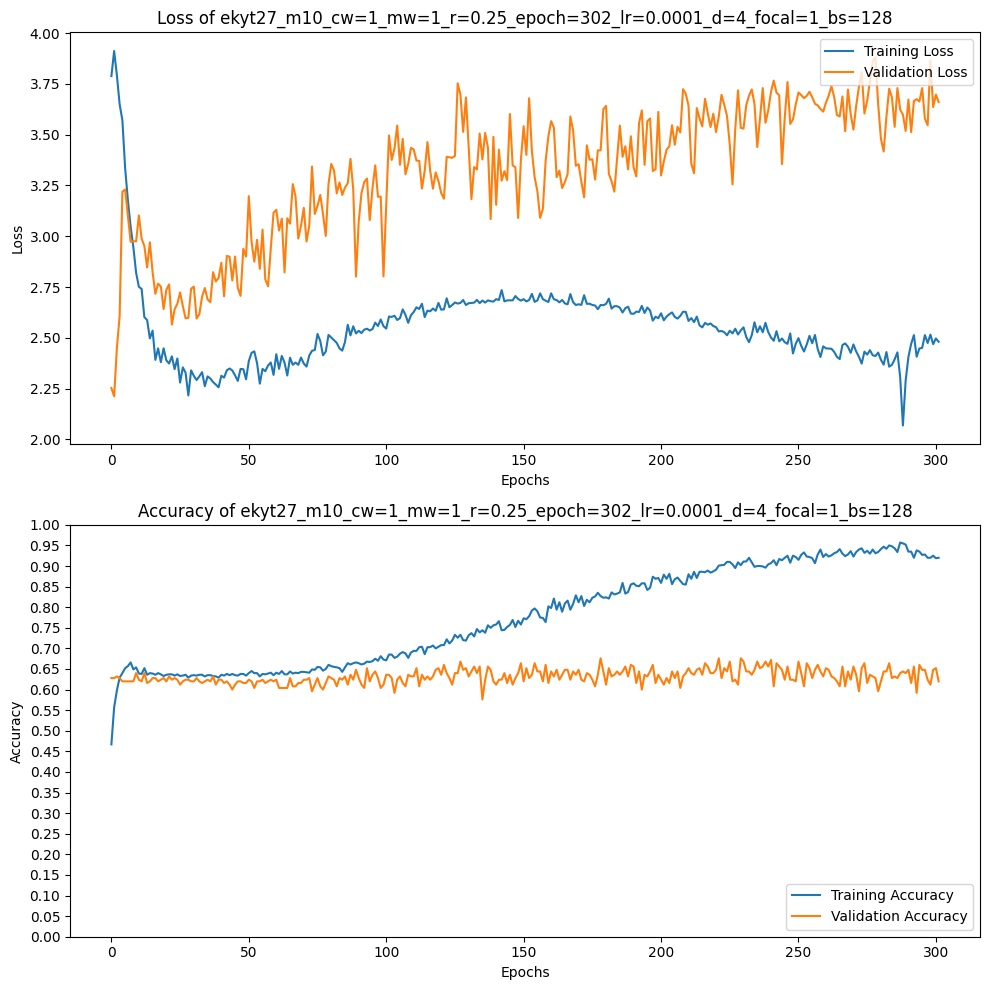

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Create a figure with two subplots
fig, ax1 = plt.subplots(2, 1, figsize=(10, 10))

# Plot training and validation loss history
ax1[0].plot(train_loss_hist, label='Training Loss')
ax1[0].plot(valid_loss_hist, label='Validation Loss')
ax1[0].set_xlabel('Epochs')
ax1[0].set_ylabel('Loss')
ax1[0].legend(loc='upper right')
ax1[0].set_title(f'Loss of ' + save_name)

# Plot training and validation accuracy history
ax1[1].set_ylim(0, 1)
ax1[1].yaxis.set_major_locator(MultipleLocator(0.05))
ax1[1].plot(train_acc_hist, label='Training Accuracy')
ax1[1].plot(valid_acc_hist, label='Validation Accuracy')
ax1[1].set_xlabel('Epochs')
ax1[1].set_ylabel('Accuracy')
ax1[1].legend(loc='lower right')
ax1[1].set_title(f'Accuracy of ' + save_name)

# Save and show the combined figure
plt.tight_layout()
plt.savefig('./figures/loss_accuracy_' + save_name + '.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# Testing Stage
# model = EyeClassifierLayer('cuda').to('cuda')  # Replace with your actual model class
# model.load_state_dict(torch.load('./models/best_model.pth'))
model.to(device)
model.eval()

# Reset metrics before the evaluation
accuracy.reset()
recall.reset()
specificity.reset()
auc.reset()

# Testing loop
with torch.no_grad():
    for batch_inputs, batch_labels in test_loader:
        # Move inputs and labels to the correct device
        batch_inputs = [x.to(device) for x in batch_inputs]
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_inputs)

        # Update metrics
        accuracy.update(outputs, batch_labels)
        recall.update(outputs, batch_labels)
        specificity.update(outputs, batch_labels)
        auc.update(outputs, batch_labels)

# Compute and print the final metrics
test_acc = accuracy.compute().item()
test_recall = recall.compute().item()
test_specificity = specificity.compute().item()
test_auc = auc.compute().item()

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test Specificity: {test_specificity:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Test Accuracy: 0.6901
Test Recall: 0.4483
Test Specificity: 0.8325
Test AUC: 0.7126


In [44]:
# Function to identify misclassified instances and visualize using PCA or t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter

def get_misclassified_names(model, data_loader, X_valid, device, method='pca'):
    model.eval()
    true_labels = []
    pred_labels = []
    features = []
    
    with torch.no_grad():
        for batch_inputs, labels in data_loader:
            batch_inputs = [x.to(device) for x in batch_inputs]
            labels = labels.to(device)
            
            outputs = model(batch_inputs)
            preds = torch.round(torch.sigmoid(outputs))
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            features.extend(outputs.cpu().numpy())

    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    features = np.array(features)

    misclassified_indices = np.where(true_labels != pred_labels)[0]
    misclassified_features = features[misclassified_indices]
    misclassified_labels = true_labels[misclassified_indices]

    misclassified_names = X_valid.iloc[misclassified_indices]['name'].tolist()

    return misclassified_names

def collect_consistently_misclassified_names(model, data_loader, X_valid, device, iterations=10):
    name_counter = Counter()
    
    for _ in range(iterations):
        misclassified_names = get_misclassified_names(model, data_loader, X_valid, device)
        name_counter.update(misclassified_names)
    
    # Filter names that appear in all iterations
    consistently_misclassified_names = [name for name, count in name_counter.items() if count == iterations]
    
    return consistently_misclassified_names

In [45]:
consistently_misclassified_names = collect_consistently_misclassified_names(model, valid_loader, X_valid, device, iterations=2)

csv_file_path = "consistently_misclassified.csv"

# Load the existing CSV file if it exists, otherwise create a new one
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
else:
    df = pd.DataFrame(columns=['name', 'model'])

# Prepare the new data with the model name
new_data = pd.DataFrame(consistently_misclassified_names, columns=['name'])
new_data['model'] = save_name

# Append the new misclassified names to the DataFrame
df = pd.concat([df, new_data]).drop_duplicates().reset_index(drop=True)

# Save the updated DataFrame back to the CSV file
df.to_csv(csv_file_path, index=False)

print("Consistently misclassified names saved to:", csv_file_path)

print("Consistently misclassified names:")
for name in consistently_misclassified_names:
    print(name)

Consistently misclassified names saved to: consistently_misclassified.csv
Consistently misclassified names:
刘莹
曹跃云
朱汝玮
王树恒
潘静付
蒙少卿
林平华
孙广侠
吕云龙
陈还香
蒋志礼
陈仁娣
谭刚英
余战洪
易承庭
张东君
邹世明
贺菊桂
张荣华
于智军
张焕光
王振湘
赵淑娇
刘玉莲
王亚杰
黄耐福
王代琴
张春娣
李彩芬
高健
苏琨
韩玉华


In [46]:
batch_input, label = next(iter(train_loader))
# batch_inputs
# label
# sample_x = [torch.randn(128, 2, 770)] + [torch.randn(128, 2, 490) for i in range(9)]
# model(batch_input)

In [47]:
embeddings = [decoder(x) for decoder, x in zip(model.encoders, batch_input)]
embeddings

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__native_batch_norm)

In [ ]:
embedding = torch.cat(embeddings, dim=-1)
embedding.shape

torch.Size([128, 1280])

In [ ]:
# embeddings[5]
batch_input[5].isnan().sum(dim=2).shape

torch.Size([128, 2])